In [ ]:
import PIL


In [ ]:
import pandas as pd

# Replace 'path_to_csv' with the actual path to your CSV file
csv_file_path = 'styles.csv'

# Read the CSV file into a DataFrame
df = pd.read_csv(csv_file_path, on_bad_lines='skip')

# Now 'df' holds the DataFrame object with the data from the CSV file
print(df)

In [ ]:
Item_List = list(set(df['articleType'].tolist()))


In [ ]:
from transformers import CLIPProcessor, CLIPModel
import torch

model_id = "openai/clip-vit-base-patch32"

processor = CLIPProcessor.from_pretrained(model_id)
model = CLIPModel.from_pretrained(model_id)

# move model to device if possible
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model.to(device)

In [ ]:
tokens = processor(
    text=Item_List,
    padding=True,
    images=None,
    return_tensors='pt'
).to(device)
tokens.keys()

In [ ]:
text_emb = model.get_text_features(
    **tokens
)

In [ ]:
text_emb_list = text_emb.detach().cpu().numpy().tolist()

In [ ]:
from qdrant_client import QdrantClient, models

client = QdrantClient(url="http://localhost:6333")

client.create_collection(
    collection_name="text_embeddings",
    vectors_config=models.VectorParams(size=512, distance=models.Distance.COSINE),
)

In [ ]:
# Convert list into a list of dictionaries
payload = [{'itemtype': item} for item in Item_List]

# Show the result
print(payload)

In [ ]:
# Create a list of IDs from 1 to the length of the items list
id_list = [i for i in range(1, len(Item_List) + 1)]

# Show the result
print(id_list)

In [ ]:
client.upsert(
    collection_name="text_embeddings",
    points=models.Batch(
        ids=id_list,
        payloads=payload,
        vectors=text_emb_list,
    ),
)

In [75]:
from PIL import Image

image_query_vector = processor(
		text = None,
		images = Image.open('images/1578.jpg'),
		return_tensors="pt"
		)["pixel_values"].to(device)



In [76]:
image_query_vector_emb = model.get_image_features(image_query_vector)

In [ ]:
image_query_vector_emb.detach().cpu().numpy().tolist()[0]

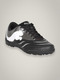

In [121]:
from IPython.display import Image
Image(filename='images/6388.jpg')

In [77]:
client.search(
    collection_name="text_embeddings",
    query_vector=image_query_vector_emb.detach().cpu().numpy().tolist()[0],
    limit=3,
)

[ScoredPoint(id=25, version=0, score=0.28064984, payload={'itemtype': 'Innerwear Vests'}, vector=None, shard_key=None),
 ScoredPoint(id=83, version=0, score=0.24891837, payload={'itemtype': 'Lounge Tshirts'}, vector=None, shard_key=None),
 ScoredPoint(id=70, version=0, score=0.24561983, payload={'itemtype': 'Camisoles'}, vector=None, shard_key=None)]

In [ ]:
client.delete_collection(collection_name="image_embeddings")
client.create_collection(
    collection_name="image_embeddings",
    vectors_config=models.VectorParams(size=512, distance=models.Distance.COSINE),
)

In [ ]:
import os
import torch
from PIL import Image
import pandas as pd

# Define the directory where the images are stored
image_directory = 'images'

# Initialize an empty list to store the data
data = []

# Loop over all files in the image directory
for i, filename in enumerate(os.listdir(image_directory)):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):  # Add any other file types if needed
        # Construct the full path to the image file
        file_path = os.path.join(image_directory, filename)
        with Image.open(file_path) as img:
             
            # Prepare the image for the model
            tokens = processor(
                text=None,
                images=img,
                return_tensors="pt"
            )["pixel_values"].to(device)
        
            # Get image embeddings from the model
            image_embeddings = model.get_image_features(
                tokens
            )
        
            # Append the filename and embeddings to the data list
            data.append((filename, image_embeddings.detach().cpu().numpy().tolist()[0])

    # Print the iteration number
    print(f'Iteration {i}: Processed {filename}')

# Create a DataFrame with the data
df = pd.DataFrame(data, columns=['Filename', 'ImageEmbeddings'])

# Display the DataFrame
print(df)

In [ ]:
# Assuming 'df' is your existing DataFrame
# Create a new 'ID' column that starts at 1 and increments by 1 for each row
df['ID'] = range(1, len(df) + 1)

# Display the updated DataFrame
print(df)

In [ ]:
# Create the list of dictionaries with "Filename" as the key
filenames_list = [{'Filename': filename} for filename in df['Filename']]

# Create the list of ImageEmbeddings (assuming ImageTensor is already a list of embeddings)
image_embeddings_list = df['ImageEmbeddings'].tolist()

# Create the list of IDs
ids_list = df['ID'].tolist()

In [ ]:
# Assuming 'client' is your database client and 'models' is a module providing the Batch class
# And assuming your lists are named 'ids_list', 'filenames_list', and 'image_embeddings_list'

batch_size = 1000
total_points = len(ids_list)

for start_index in range(0, total_points, batch_size):
    # End index is the start of the next batch or the end of the list
    end_index = min(start_index + batch_size, total_points)
    
    # Slice the lists to create the current batch
    batch_ids = ids_list[start_index:end_index]
    batch_filenames = filenames_list[start_index:end_index]
    batch_image_embeddings = image_embeddings_list[start_index:end_index]
    
    # Upsert the current batch
    client.upsert(
        collection_name="image_embeddings",
        points=models.Batch(
            ids=batch_ids,
            payloads=batch_filenames,
            vectors=batch_image_embeddings,
        ),
    )

In [ ]:
client.scroll(collection_name="image_embeddings", limit=20000)

In [102]:
def image_classifier(image):
   # Prepare the image for the model
    tokens = processor(
        text=None,
        images=image,
        return_tensors="pt"
    )["pixel_values"].to(device)

    # Get image embeddings from the model
    image_embeddings = model.get_image_features(
        tokens
    )

    query_vector = image_embeddings.detach().cpu().numpy().tolist()[0]
        
    record = client.search(
        collection_name="text_embeddings",
        query_vector=query_vector,
        limit=1,
    )
    
    return record[0].payload['itemtype']


In [113]:
def image_path_list(image):
       # Prepare the image for the model
    tokens = processor(
        text=None,
        images=image,
        return_tensors="pt"
    )["pixel_values"].to(device)

    # Get image embeddings from the model
    image_embeddings = model.get_image_features(
        tokens
    )

    query_vector = image_embeddings.detach().cpu().numpy().tolist()[0]
        
    record = client.search(
        collection_name="image_embeddings",
        query_vector=query_vector,
        limit=10,
    )
    
    return [('fashion-dataset/fashion-dataset/images/' + element.payload['Filename'], None) for element in record]
    
    

In [120]:
import gradio as gr

with gr.Blocks() as demo:
    
    with gr.Row():
        upload_image = gr.Image(label= "Upload Your Image", type = 'pil')
        classifier_text = gr.Textbox(label= "Type of Item")
        
    with gr.Row():
        image_gallery = gr.Gallery(label= "Similar items in the inventory", object_fit= 'contain', columns=[5], rows=[2],)
        
    with gr.Row():
        clr_btn = gr.Button(value= "Clear")
    
    first_step = upload_image.upload(fn= image_classifier, inputs= upload_image, outputs= classifier_text)
    first_step.then(fn= image_path_list, inputs= upload_image, outputs = image_gallery)
    clr_btn.click(fn=lambda: (None, None, []), inputs=None, outputs=[upload_image, classifier_text, image_gallery])
    
demo.launch(share=True)

Running on local URL:  http://127.0.0.1:7867
Running on public URL: https://9fd542f880fe689b07.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
